    JACOB KNOPPING
    1/26/2020
    
__20.6 DRILL: RANDOM FOREST MODEL__
    
So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [4]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

In [5]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


In [6]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [7]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

In [9]:
y2015.select_dtypes(include=['float64']).columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_wit

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [19]:
y2015.dropna(inplace = True)
y2015.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
emp_length                        0
home_ownership                    0
annual_inc                        0
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
purpose                           0
title                             0
dti                               0
delinq_2yrs                       0
inq_last_6mths                    0
mths_since_last_delinq            0
open_acc                          0
pub_rec                           0
revol_bal                         0
total_acc                         0
initial_list_status               0
out_prncp                   

In [20]:
y2015_numeric = y2015.select_dtypes(include=['float64'])
y2015_categorical = y2015.select_dtypes(include=['object'])

In [21]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(y2015_numeric)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00002728  0.99896744 -0.00741122 ...  0.01837364  0.02419325
   0.02696946]
 [ 0.99896744  1.00002728 -0.00727728 ...  0.01803507  0.02453128
   0.0264635 ]
 [-0.00741122 -0.00727728  1.00002728 ...  0.21079166  0.30393261
   0.17775487]
 ...
 [ 0.01837364  0.01803507  0.21079166 ...  1.00002728  0.18014959
   0.89470319]
 [ 0.02419325  0.02453128  0.30393261 ...  0.18014959  1.00002728
   0.07059941]
 [ 0.02696946  0.0264635   0.17775487 ...  0.89470319  0.07059941
   1.00002728]]


In [22]:
y2015_numeric.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
int_rate                          0
installment                       0
annual_inc                        0
dti                               0
delinq_2yrs                       0
inq_last_6mths                    0
mths_since_last_delinq            0
open_acc                          0
pub_rec                           0
revol_bal                         0
total_acc                         0
out_prncp                         0
out_prncp_inv                     0
total_pymnt                       0
total_pymnt_inv                   0
total_rec_prncp                   0
total_rec_int                     0
total_rec_late_fee                0
recoveries                        0
collection_recovery_fee           0
last_pymnt_amnt                   0
collections_12_mths_ex_med        0
mths_since_last_major_derog 

In [23]:
#y2015_numeric = y2015_floats.dropna()
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[ 0.0209967   0.02100352 -0.25844114 -0.25844114 -0.25845222 -0.06085051
 -0.25044366 -0.09230713 -0.0268324  -0.00402455 -0.02869489  0.01127002
 -0.16258132  0.00892703 -0.12593683 -0.14858203 -0.23037763 -0.23041023
 -0.23910603 -0.23908286 -0.19909033 -0.21455394 -0.02044565  0.
  0.         -0.14318775  0.00280783 -0.00049327  0.         -0.00294668
 -0.00528834 -0.1186515  -0.155725   -0.08875105 -0.0509594  -0.10496529
  0.00082512 -0.00840614 -0.00168263 -0.04048762 -0.06736872  0.02892929
  0.03011988 -0.07562138  0.03019203  0.00913234  0.02933913  0.01156776
 -0.00233097 -0.14499215 -0.14472714 -0.15979472 -0.14031613 -0.04684442
 -0.15747966 -0.14215048 -0.1447278  -0.16238479 -0.00339266 -0.00350642
  0.00354769 -0.06701392 -0.0648884   0.00708368  0.01648898 -0.00559914
 -0.12423732 -0.11982292 -0.16220631 -0.08996252]
Eigenvalue 1: 10.59137198909631
----------------------------------------
Eigenvector 2: 
[ 0.03020533  0.03006325 -0.16850818 -0.16850818 -

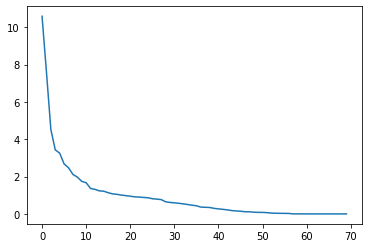

[ 1.05913720e+01  7.59768636e+00  4.51923994e+00  3.43260069e+00
  3.25426568e+00  2.67947129e+00  2.47195709e+00  2.11521687e+00
  1.97369445e+00  1.74410080e+00  1.67020390e+00  1.36468464e+00
  1.31611168e+00  1.23416582e+00  1.21722049e+00  1.13543623e+00
  1.07403177e+00  1.04793574e+00  1.00892003e+00  9.80300523e-01
  9.49130299e-01  9.15136037e-01  9.03204872e-01  8.82374316e-01
  8.66834620e-01  8.14297020e-01  7.93992336e-01  7.67957293e-01
  6.52481904e-01  6.13812930e-01  5.96009177e-01  5.68235429e-01
  5.39028670e-01  5.04428539e-01  4.66611379e-01  4.37683442e-01
  3.65643653e-01  3.55889684e-01  3.44898032e-01  2.98241684e-01
  2.69127173e-01  2.46039685e-01  2.16722132e-01  1.79100733e-01
  1.58603199e-01  1.42803299e-01  1.16490059e-01  1.14389254e-01
  9.25473794e-02  8.29629182e-02  8.01930318e-02  6.81574127e-02
  4.47111677e-02  3.59981841e-02  3.06165876e-02  2.89210685e-02
  2.41889065e-02  1.89167803e-03  1.94156951e-03  1.05258734e-03
  8.40452392e-04  2.15518

In [24]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

19 components

In [26]:
sklearn_pca = PCA(n_components=19)
principalComponents = sklearn_pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca_1',
                          'pca_2', 
                          'pca_3', 
                          'pca_4', 
                          'pca_5', 
                          'pca_6', 
                          'pca_7', 
                          'pca_8', 
                          'pca_9', 
                          'pca_10', 
                          'pca_11', 
                          'pca_12', 
                          'pca_13', 
                          'pca_14', 
                          'pca_15', 
                          'pca_16', 
                          'pca_17', 
                          'pca_18', 
                          'pca_19'])

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.15807587 0.11339521 0.0674495  0.05123144 0.04856977 0.03999089
 0.0368938  0.03156888 0.02945713 0.02602897 0.02492716 0.02036362
 0.01963169 0.01840795 0.01814455 0.01689204 0.01600596 0.01559942
 0.01492657]


In [27]:
principalDf

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19
0,7.417852,6.165087,1.107573,-5.749476,14.952648,8.694947,-6.809306,9.074481,-2.643773,4.267971,-5.037686,8.144681,-2.583801,-2.066414,-3.929197,2.614030,2.084070,-7.409233,-0.765328
1,-5.137184,0.258051,-0.679482,0.606604,0.458688,2.215220,-1.530409,-1.259001,-1.131400,-0.322178,0.232346,0.008673,0.611229,0.696198,0.316302,-0.127831,0.116017,0.143588,-0.009567
2,-1.275641,-1.550790,-0.939930,-0.114916,-0.226048,1.406273,-1.789986,0.932493,1.451869,0.426511,-1.197783,-0.549336,2.013205,-1.318313,0.225400,1.708537,0.598745,-0.226836,0.564423
3,0.062422,0.402459,0.704504,4.393331,1.780503,-0.404711,-1.180429,-0.341435,1.221169,-0.218904,0.837808,-0.445597,1.438503,-0.174215,-0.897170,0.458960,-0.043599,0.424621,0.387740
4,0.721686,0.112185,0.600260,2.944289,0.953468,1.327313,-1.148857,-0.854576,3.054801,-1.863892,2.217714,1.795642,1.045731,-0.123024,-1.292567,1.436496,0.590600,-0.417938,-1.176220
5,-0.204066,-2.212054,2.782799,3.430667,0.204180,2.169154,-1.634969,-1.046914,1.377561,1.765992,-3.605045,-1.064516,0.803729,3.283249,0.023284,0.733451,0.416184,0.485420,0.646439
6,0.358299,1.028111,-1.540734,2.959319,-0.525194,-1.511684,-2.845806,0.092585,-0.521372,0.477350,0.348852,-0.317410,0.700168,0.334650,-1.290245,-0.469431,-0.298215,0.725678,0.220392
7,4.801469,-3.283111,-0.739968,1.226287,0.739927,0.830243,-3.513359,1.954470,2.161227,-0.731006,1.007419,-1.437649,-0.603945,-0.796294,-0.212834,0.612941,0.102316,-0.764331,-0.018906
8,0.346594,0.629849,-2.968214,0.325832,1.394696,1.265595,-2.872887,-0.871983,-0.688265,0.028517,0.450048,0.453892,0.210565,0.565283,0.136788,-0.681599,-0.250329,-1.288987,-0.010948
9,-3.443067,-1.242367,-1.185700,-1.235402,-0.261764,0.625457,-2.524206,-0.993843,-1.550907,0.201715,-0.541745,0.151172,0.758838,0.052905,0.105288,-0.381244,0.184817,0.580263,-0.016700


In [35]:
len(y2015['loan_status'])

36654

In [36]:
len(principalDf)

36654

In [38]:
len(pd.get_dummies(y2015_categorical))

36654

In [55]:
features_df = pd.concat((principalDf.reset_index(drop=True),
                       y2015['loan_status'].reset_index(drop=True)),
                       axis=1)

In [56]:
features_df.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,loan_status
0,7.417852,6.165087,1.107573,-5.749476,14.952648,8.694947,-6.809306,9.074481,-2.643773,4.267971,-5.037686,8.144681,-2.583801,-2.066414,-3.929197,2.614030,2.084070,-7.409233,-0.765328,Current
1,-5.137184,0.258051,-0.679482,0.606604,0.458688,2.215220,-1.530409,-1.259001,-1.131400,-0.322178,0.232346,0.008673,0.611229,0.696198,0.316302,-0.127831,0.116017,0.143588,-0.009567,Current
2,-1.275641,-1.550790,-0.939930,-0.114916,-0.226048,1.406273,-1.789986,0.932493,1.451869,0.426511,-1.197783,-0.549336,2.013205,-1.318313,0.225400,1.708537,0.598745,-0.226836,0.564423,Current
3,0.062422,0.402459,0.704504,4.393331,1.780503,-0.404711,-1.180429,-0.341435,1.221169,-0.218904,0.837808,-0.445597,1.438503,-0.174215,-0.897170,0.458960,-0.043599,0.424621,0.387740,Current
4,0.721686,0.112185,0.600260,2.944289,0.953468,1.327313,-1.148857,-0.854576,3.054801,-1.863892,2.217714,1.795642,1.045731,-0.123024,-1.292567,1.436496,0.590600,-0.417938,-1.176220,Current


In [57]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
#only use pca values, ignore categorical
X = features_df.drop('loan_status', 1)
Y = features_df['loan_status']


cross_val_score(rfc, X, Y, cv=10)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

array([0.93155168, 0.93182438, 0.93262411, 0.93180578, 0.93316967,
       0.93260573, 0.93424284, 0.93260573, 0.93313319, 0.93202293])

__Our goal was accomplished! We were able to maintain at least 90% accuracy in a 10-fold cross validation, while only using n=19 pca components (versus using 103 variables before).__

Note: For the purpose of time, data cleaning dropped variables that may have had useful information. In turn, less pca components likely could have been used to produce these same results. If time allows, go back and process data differently and see how the number of pca components needed changes.